# Plot XAI results
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.3.0

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import shash_tfp
from build_data import build_hurricane_data
import build_model
import model_diagnostics
from silence_tensorflow import silence_tensorflow
import prediction
from sklearn.neighbors import KernelDensity
import pandas as pd
from tqdm import tqdm
import imp

import warnings
warnings.filterwarnings("ignore")

silence_tensorflow()
dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__  = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "07 July 2022"

EXP_NAME_LIST = (
#                  "intensity301_EPCP24",
                 # "intensity302_EPCP48",    
#                  "intensity303_EPCP72",
#                  "intensity304_EPCP96",    
#                  "intensity305_EPCP120",
    
#                  "intensity201_AL24",
                 "intensity202_AL48",    
#                  "intensity203_AL72",
#                  "intensity204_AL96",    
#                  "intensity205_AL120",            
                 )

PLOT_SEED_VECTOR = {"intensity301_EPCP24": None,
                    "intensity302_EPCP48": 739,
                    "intensity201_AL24": None,                    
                    "intensity202_AL48": 416,
                   }
TESTING_YEAR_VECTOR = {"intensity301_EPCP24": 2020,
                       "intensity302_EPCP48": 2020,
                       "intensity201_AL24": 2018,                       
                       "intensity202_AL48": 2018,
                      }
feature_names = [
            "NCI","VMAX0",
            "DSDV", "LGDV", "HWDV", "AVDV",
            "VMXC", "DV12", "SLAT", "SSTN", "SHDC", "DTL",
        ]
SHASH_INCS = np.arange(-160,161,1)
OVERWRITE_METRICS = False
DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"

## Functions

In [3]:
def get_storm_details(df, isample):
    storm = df.iloc[isample]
    storm_name = storm['Name']
    storm_ftime = storm['ftime(hr)']
    storm_month = str(storm['time'])[:-4]
    storm_day = str(storm['time'])[-4:-2]
    storm_hour = str(storm['time'])[-2:]
    storm_year = storm['year']

    details = storm_name + ' ' + str(storm_year) + '-' + str(storm_month) + '-' + str(storm_day) + ' ' + str(storm_hour) + '00 @' + str(storm_ftime) + 'hr'
    
    return details

In [4]:
FS = 16
colors = ('#284E60','#E1A730','#D95980','#C3B1E1','#351F27','#A9C961')

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

In [5]:
def get_predictions(model, x_eval):
    runs = 5_000
    shash_cpd = np.zeros((np.shape(x_eval)[0],len(SHASH_INCS)))
    shash_med = np.zeros((np.shape(x_eval)[0],))
    mc_cpd = np.zeros((np.shape(x_eval)[0],runs))
    tf.random.set_seed(network_seed)

    if settings["uncertainty_type"] == "bnn":               
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model.predict(x_eval),np.shape(mc_cpd)[0])
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"] == "mcdrop":  
        # loop through runs for mcdrop calculation  
        for i in tqdm(range(0,runs)):
            mc_cpd[:,i] = np.reshape(model(x_eval,training=True),np.shape(mc_cpd)[0])    
        return mc_cpd, np.median(mc_cpd,axis=1)
    
    elif settings["uncertainty_type"][:5] == "shash": 
        # loop through samples for shash calculation and get PDF for each sample
        for j in tqdm(range(0,np.shape(shash_cpd)[0])):
            mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_eval[np.newaxis,j], model )
            dist = shash_tfp.Shash(mu_pred, sigma_pred, gamma_pred, tau_pred)
            shash_cpd[j,:] = dist.prob(SHASH_INCS)    
            shash_med[j]   = dist.median()
        return shash_cpd, shash_med
    
    else:
        raise NotImplementedError('no such uncertainty type')


## Compute Metrics

In [6]:
for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    TESTING_YEARS = TESTING_YEAR_VECTOR[exp_name]
    settings["years_test"] = (TESTING_YEARS,)
    
    RNG_SEED = PLOT_SEED_VECTOR[exp_name]
    settings['rng_seed'] = RNG_SEED
    seed_dict = {}
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.  

    #----------------------------------------------------------------------------------------------------
    # get the data
    (
        data_summary,        
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_test,
        onehot_test,        
        x_valtest,
        onehot_valtest,
        df_train,
        df_val,
        df_test,
        df_valtest,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)

    #----------------------------------------------------------------------------------------------------
    # get the model
    # Make, compile, and train the model
    tf.keras.backend.clear_session()            
    model = build_model.make_model(
        settings,
        x_train,
        onehot_train,
        model_compile=False,
    )   
    model_name = (
        exp_name + "_" + 
        str(TESTING_YEARS) + '_' +
        settings["uncertainty_type"] + '_' + 
        f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
    )

    try:
        model.load_weights(MODEL_PATH + model_name + "_weights.h5")
    except:
        print(model_name + ': model does not exist. skipping...')
        continue

    pred_cpd_test = get_predictions(model, x_test)
        
    

100%|██████████████████████████████████████████████████████████████████████████████| 243/243 [00:10<00:00, 22.74it/s]


In [7]:
def quick_plot(pred_cpd_test, sample):
    plt.figure(figsize=(2,2))
    plt.plot(SHASH_INCS, pred_cpd_test[0][sample,:])
    plt.axvline(x=pred_cpd_test[1][sample],linestyle='--',color='red')
    plt.xlim(-45,45)
    plt.show()

## Importance

In [8]:
norm_mean = model.layers[1].get_weights()[0]
norm_var = model.layers[1].get_weights()[1]
norm_std = np.sqrt(norm_var)

### Feature Importance (setting to the mean)

In [9]:
feature_importance = np.empty((x_test.shape[0],12,3))
mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_test, model )    

for ifeature in range(x_test.shape[1]):
    x_input = np.copy(x_test)
    x_input[:,ifeature] = norm_mean[ifeature]

    (mu_pred_perturb, 
     sigma_pred_perturb, 
     gamma_pred_perturb, 
     tau_pred_perturb) = prediction.params( x_input, model )
    feature_importance[:,ifeature,0] = mu_pred_perturb-mu_pred
    feature_importance[:,ifeature,1] = sigma_pred_perturb-sigma_pred
    feature_importance[:,ifeature,2] = gamma_pred_perturb-gamma_pred
    
mean_feature_importance=np.mean(np.abs(feature_importance),axis=0)
mean_feature_importance.shape        

(12, 3)

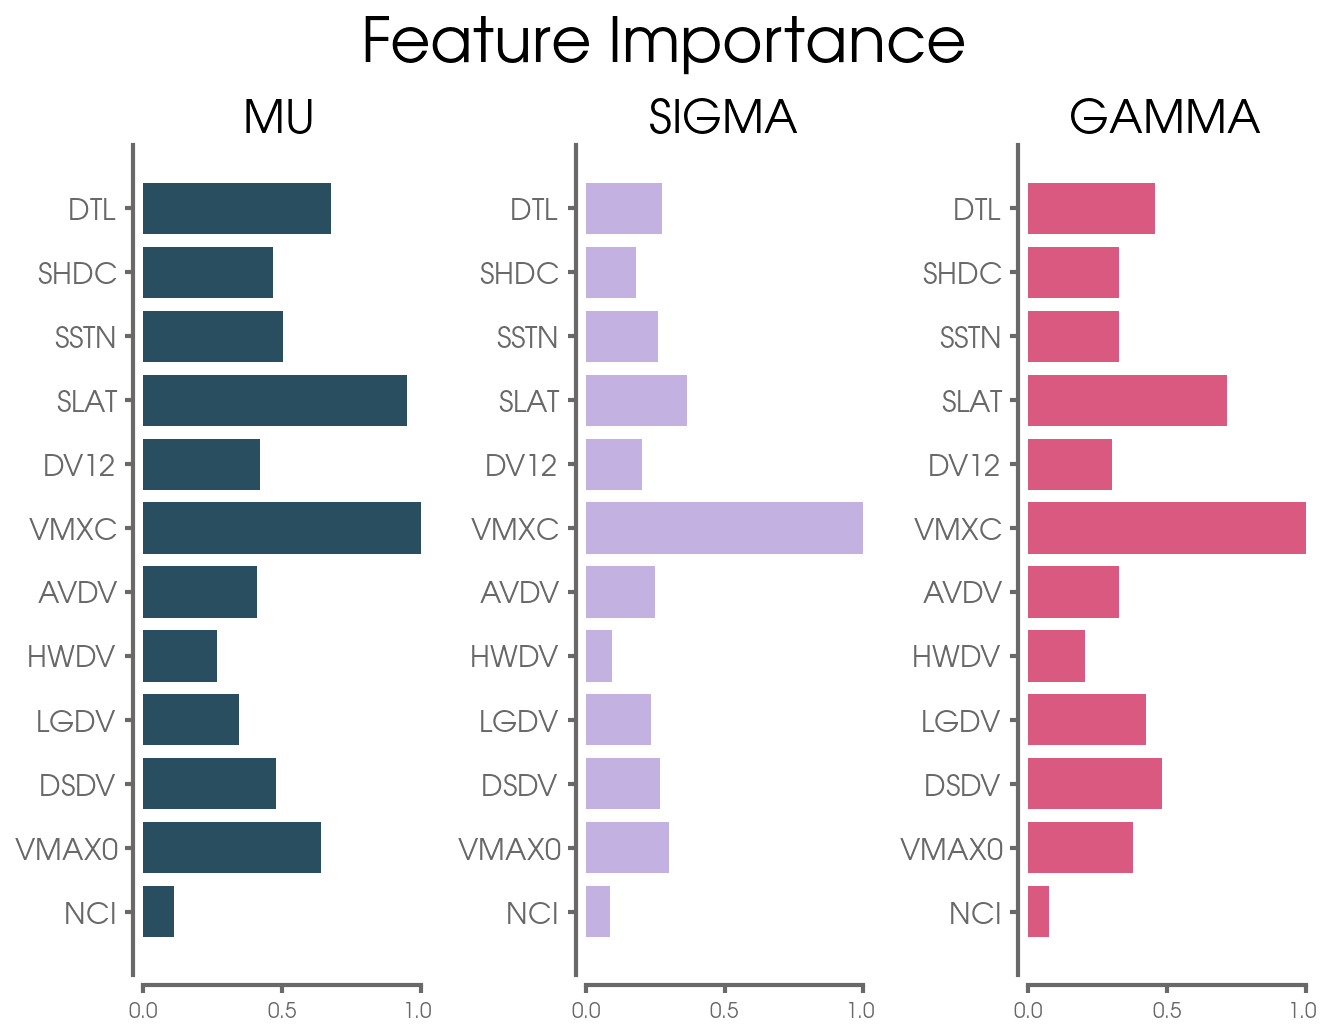

In [10]:
colors = ('#284E60','#C3B1E1','#D95980','#C3B1E1',)
param_names = ('MU','SIGMA','GAMMA')
fig, axs = plt.subplots(1,3,figsize=(9,7))
for iparam in range(len(param_names)):
    ax = axs[iparam]
    ax.barh(range(mean_feature_importance.shape[0]),
            mean_feature_importance[:,iparam]/mean_feature_importance[:,iparam].max(),
            color=colors[iparam],
           )
    format_spines(ax)    
    ax.set_yticks(range(mean_feature_importance.shape[0]),
                  feature_names,
                  fontsize=14,
                 )
    ax.set_title(param_names[iparam],fontsize=22)
    xvals = ax.get_xticks()
    ax.set_xticks(xvals,xvals.round(1))
    ax.set_xlim(0,1)

plt.suptitle('Feature Importance',fontsize=30)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'featureImportance_' + model_name + '.png', dpi=dpiFig)    
plt.show()

### Permutation Importance

In [11]:
rng = np.random.default_rng(7888)
perm_importance = np.empty((5, x_test.shape[0],12,3))

mu_pred, sigma_pred, gamma_pred, tau_pred = prediction.params( x_test, model )    
for loop in range(5):
    for ifeature in range(x_input.shape[1]):
        x_input = np.copy(x_test)
        x_input[:,ifeature] = rng.choice(x_input[:,ifeature],x_input.shape[0],replace=False)

        (mu_pred_perturb, 
         sigma_pred_perturb, 
         gamma_pred_perturb, 
         tau_pred_perturb) = prediction.params( x_input, model )
        perm_importance[loop,:,ifeature,0] = mu_pred_perturb-mu_pred
        perm_importance[loop,:,ifeature,1] = sigma_pred_perturb-sigma_pred
        perm_importance[loop,:,ifeature,2] = gamma_pred_perturb-gamma_pred
        
mean_perm_importance=np.mean(np.mean(np.abs(perm_importance),axis=1),axis=0)
mean_perm_importance.shape        

(12, 3)

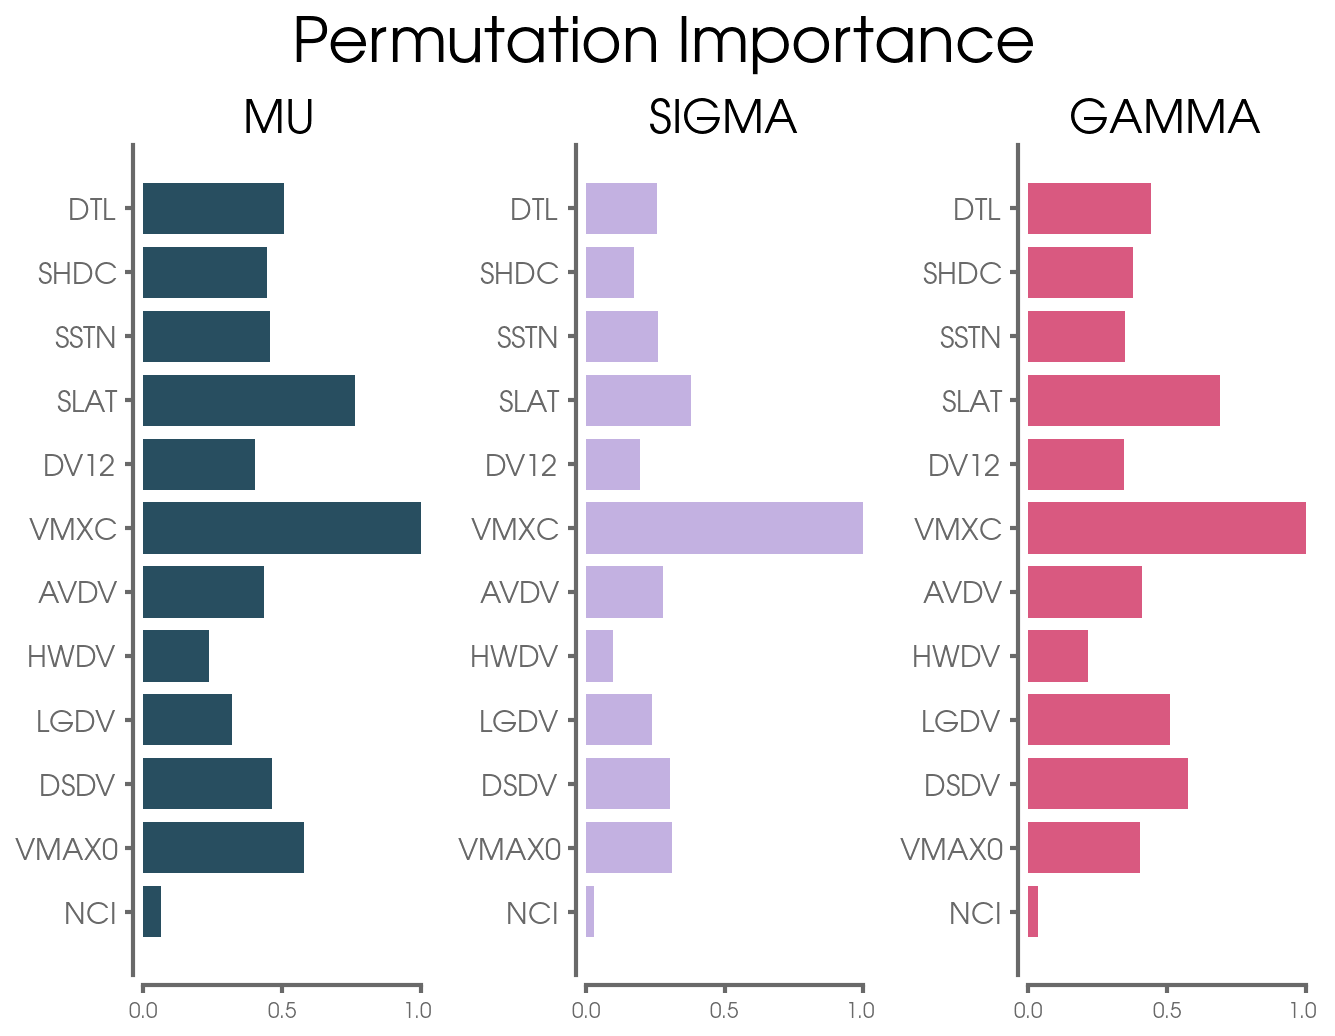

In [12]:
colors = ('#284E60','#C3B1E1','#D95980','#C3B1E1',)
param_names = ('MU','SIGMA','GAMMA')
fig, axs = plt.subplots(1,3,figsize=(9,7))
for iparam in range(len(param_names)):
    ax = axs[iparam]
    ax.barh(range(mean_perm_importance.shape[0]),
            mean_perm_importance[:,iparam]/mean_perm_importance[:,iparam].max(),
            color=colors[iparam],
           )
    format_spines(ax)    
    ax.set_yticks(range(mean_perm_importance.shape[0]),
                  feature_names,
                  fontsize=14,
                 )
    ax.set_title(param_names[iparam],fontsize=22)
    xvals = ax.get_xticks()
    ax.set_xticks(xvals,xvals.round(1))
    ax.set_xlim(0,1)

plt.suptitle('Permutation Importance',fontsize=30)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'permutationImportance_' + model_name + '.png', dpi=dpiFig)    
plt.show()

## Gradient for XAI

In [13]:
def get_gradients(model, inputs, top_pred_idx=None):
    """Computes the gradients of outputs w.r.t input image.

    Args:
        inputs: 2D/3D/4D matrix of samples
        top_pred_idx: (optional) Predicted label for the x_data
                      if classification problem. If regression,
                      do not include.

    Returns:
        Gradients of the predictions w.r.t img_input
    """
    inputs = tf.cast(inputs, tf.float32)

    with tf.GradientTape() as tape:
        tape.watch(inputs)
        
        # Run the forward pass of the layer and record operations
        # on GradientTape.
        preds = model(inputs, training=False)  
        
        # For classification, grab the top class
        if top_pred_idx is not None:
            preds = preds[:, top_pred_idx]
        
    # Use the gradient tape to automatically retrieve
    # the gradients of the trainable variables with respect to the loss.        
    grads = tape.gradient(preds, inputs)
    return grads


In [14]:
NORM = False

if NORM:
    raise Warning("something is wrong here, might need to re-compile the model?")
    model_nonorm = tf.keras.models.clone_model(model)
    w = model_nonorm.layers[1].get_weights()
    model_nonorm.layers[1].set_weights([np.zeros(np.shape(norm_mean)).astype('float32'),
                                        np.ones(np.shape(norm_mean)).astype('float32'),
                                        w[-1]]
                                      )

    grads = np.zeros((np.shape(x_test)[0],np.shape(x_test)[1],3))
    grads[:,:,0] = get_gradients(model_nonorm,(x_test-norm_mean)/norm_std,0).numpy()
    grads[:,:,1] = get_gradients(model_nonorm,(x_test-norm_mean)/norm_std,1).numpy()
    grads[:,:,2] = get_gradients(model_nonorm,(x_test-norm_mean)/norm_std,2).numpy()
    
else:    
    grads = np.zeros((np.shape(x_test)[0],np.shape(x_test)[1],3))
    grads[:,:,0] = get_gradients(model,x_test,0).numpy()
    grads[:,:,1] = get_gradients(model,x_test,1).numpy()
    grads[:,:,2] = get_gradients(model,x_test,2).numpy()
    
mean_grads = np.mean(np.abs(grads),axis=0)*norm_std[:,np.newaxis]
np.shape(grads)

(243, 12, 3)

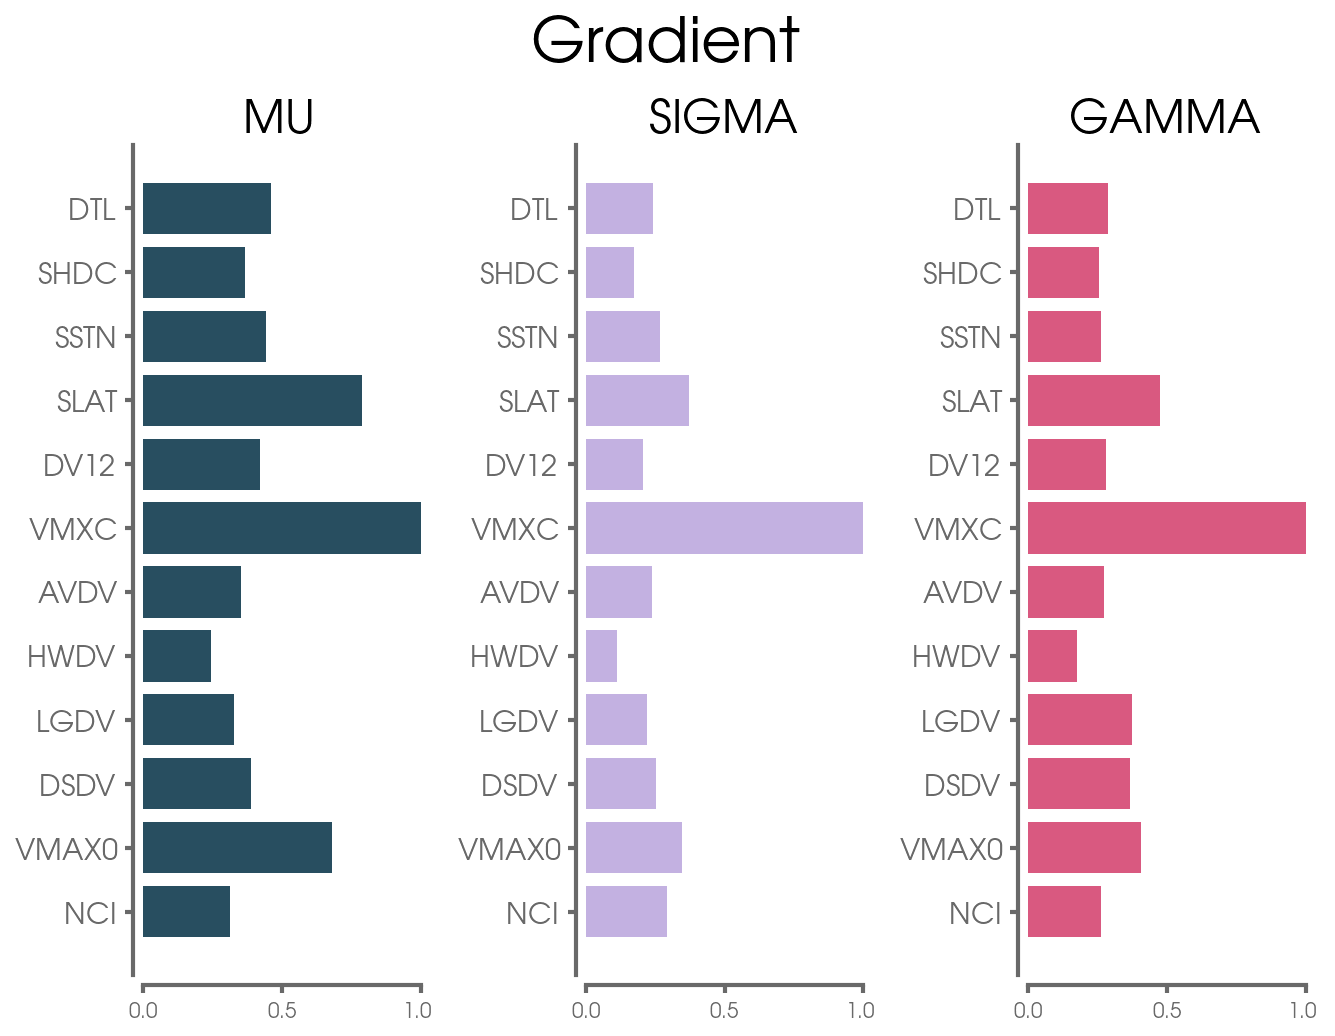

In [15]:
# dpred/dfeature = dpred/(1 SST K) = dpred * 1/(1K) * (19K / 1_sigma) 

colors = ('#284E60','#C3B1E1','#D95980','#C3B1E1',)
param_names = ('MU','SIGMA','GAMMA')
fig, axs = plt.subplots(1,3,figsize=(9,7))
for iparam in range(len(param_names)):
    ax = axs[iparam]
    ax.barh(range(mean_grads.shape[0]),
            mean_grads[:,iparam]/mean_grads[:,iparam].max(),            
            color=colors[iparam],
           )
    format_spines(ax)    
    ax.set_yticks(range(mean_grads.shape[0]),
                  feature_names,
                  fontsize=14,
                 )
    ax.set_title(param_names[iparam],fontsize=22)
    xvals = ax.get_xticks()
    ax.set_xticks(xvals,xvals.round(1))
    ax.set_xlim(0,1)

plt.suptitle('Gradient',fontsize=30)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'gradient_' + model_name + '.png', dpi=dpiFig)    
plt.show()

## Case Studies

In [16]:
# sample = 30
# df_test[df_test['Name']=='MARIE']

sample=175
df_test[df_test['Name']=='MICHAEL']



,ATCF,Name,year,time,ftime(hr),VMAX0,NCI,OBDV,DSDV,LGDV,...,EMDX,EGDX,HWDX,LONC,OBDY,AVDY,EMDY,EGDY,HWDY,LATC
16,AL14,MICHAEL,2018,100706,48,30.0,4,27.2,-2.8,-12.8,...,-101.8,142.1,30.3,86.8,-41.7,25.0,-97.2,-19.4,91.7,24.1
54,AL14,MICHAEL,2018,100900,48,75.0,4,24.2,-3.8,-1.8,...,-71.4,108.5,23.6,84.6,2.8,-97.2,-97.2,91.7,102.8,31.5
81,AL14,MICHAEL,2018,100718,48,40.0,4,25.2,1.2,-5.8,...,-75.8,105.9,5.0,86.7,61.1,16.7,-105.5,-61.1,150.0,25.1
86,AL14,MICHAEL,2018,100818,48,70.0,4,53.2,1.2,4.2,...,-65.1,98.1,-7.2,85.6,11.1,-11.1,-66.7,88.9,-11.1,30.1
101,AL14,MICHAEL,2018,100912,48,90.0,4,2.2,-4.8,-4.8,...,-49.4,81.5,25.6,82.9,161.1,-38.9,-105.5,83.3,61.1,32.7
102,AL14,MICHAEL,2018,100906,48,80.0,4,0.5,-6.5,-6.5,...,-42.7,70.8,23.5,84.1,125.0,-63.9,-86.1,47.2,102.8,31.7
138,AL14,MICHAEL,2018,100918,48,105.0,4,-0.8,-9.8,-9.8,...,-51.0,106.0,-32.3,81.2,205.5,-16.7,-72.2,50.0,38.9,33.8
141,AL14,MICHAEL,2018,100712,48,30.0,4,24.0,-7.0,-19.0,...,-108.6,103.2,32.7,86.8,-41.7,25.0,-86.1,2.8,58.3,25.0
175,AL14,MICHAEL,2018,100800,48,50.0,4,20.0,-5.0,-6.0,...,-50.0,129.7,-59.4,86.3,30.6,52.8,-125.0,-58.3,130.5,26.3
183,AL14,MICHAEL,2018,100812,48,65.0,4,35.8,1.8,3.8,...,-29.5,39.2,9.7,86.1,52.8,152.8,-158.3,-69.4,75.0,28.5


In [17]:
details = get_storm_details(df_test,sample)
print(grads.shape)
sample_grad = grads[sample,:,:]*norm_std[:,np.newaxis]
# sample_grad = grads[sample,:,:]*x_test[sample,:][:,np.newaxis]
print(sample_grad.shape)

(243, 12, 3)
(12, 3)


In [21]:
feature_names

['NCI',
 'VMAX0',
 'DSDV',
 'LGDV',
 'HWDV',
 'AVDV',
 'VMXC',
 'DV12',
 'SLAT',
 'SSTN',
 'SHDC',
 'DTL']

In [19]:
import copy
feature_names_plot = copy.deepcopy(feature_names)
feature_names_plot = [s.replace('LGDV', 'LGEM') for s in feature_names_plot]
feature_names_plot = [s.replace('HWDV', 'HWFI') for s in feature_names_plot]
feature_names_plot = [s.replace('DSDV', 'DSHP') for s in feature_names_plot]
feature_names_plot = [s.replace('AVDV', 'GFSI') for s in feature_names_plot]

display(feature_names_plot)

['NCI',
 'VMAX0',
 'DSHP',
 'LGEM',
 'HWFI',
 'GFSI',
 'VMXC',
 'DV12',
 'SLAT',
 'SSTN',
 'SHDC',
 'DTL']

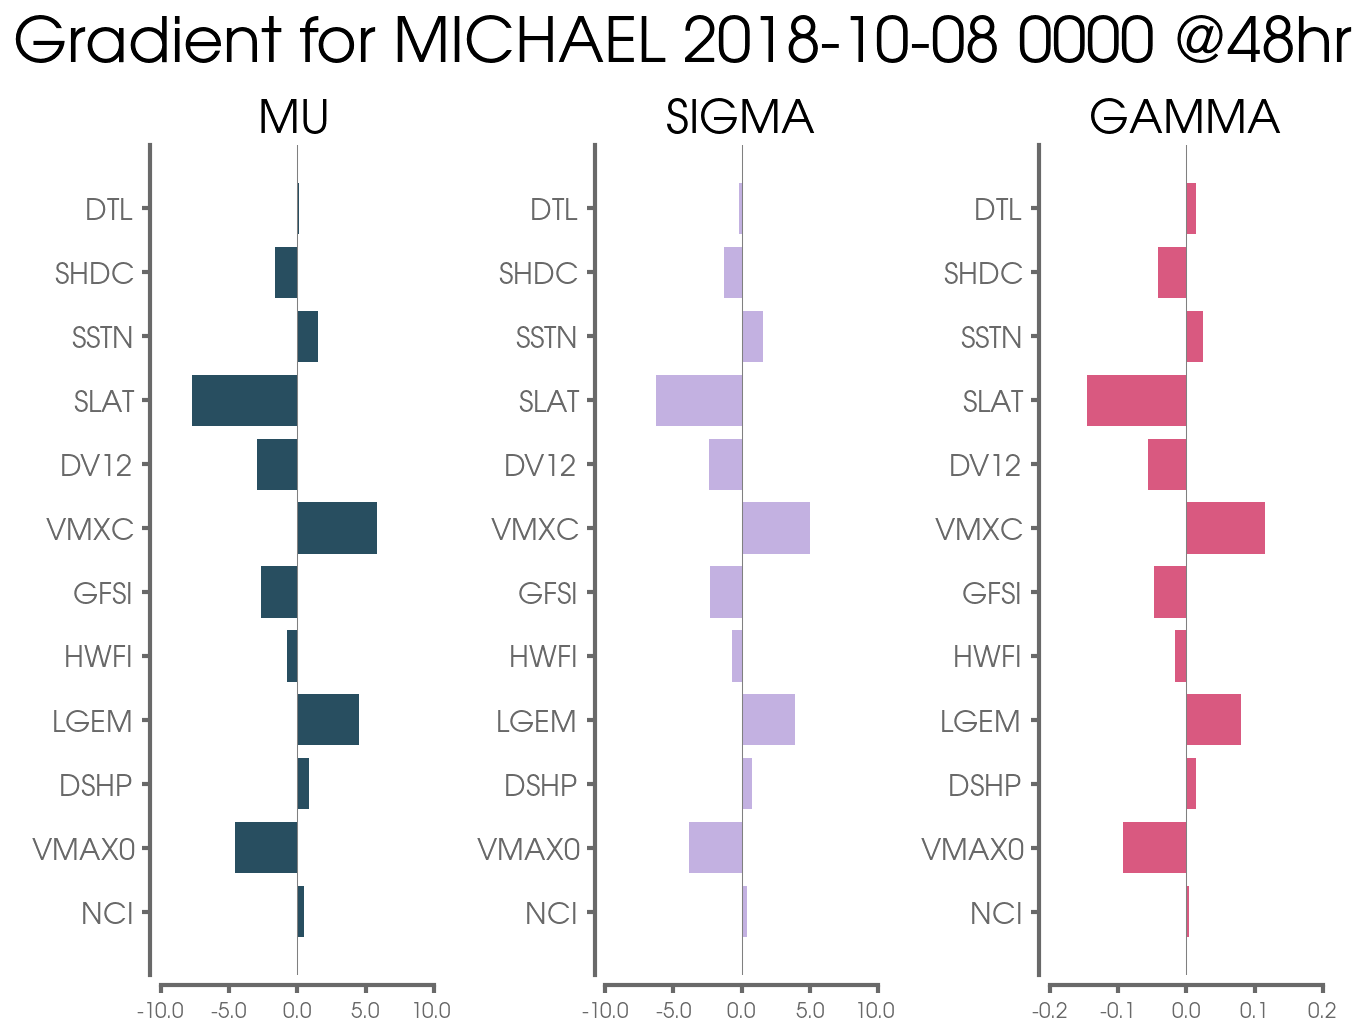

In [20]:
# dpred/dfeature = dpred/(1 SST K) = dpred * 1/(1K) * (19K / 1_sigma) 

colors = ('#284E60','#C3B1E1','#D95980','#C3B1E1',)
param_names = ('MU','SIGMA','GAMMA')
fig, axs = plt.subplots(1,3,figsize=(9,7))
for iparam in range(len(param_names)):
    ax = axs[iparam]
    ax.barh(range(sample_grad.shape[0]),
            sample_grad[:,iparam],
            color=colors[iparam],
           )
    ax.axvline(x=0,
                linewidth=.5,
                color='gray',
               )
    format_spines(ax)    
    ax.set_yticks(range(sample_grad.shape[0]),
                  feature_names_plot,
                  fontsize=14,
                 )
    ax.set_title(param_names[iparam],fontsize=22)
    xvals = ax.get_xticks()
    ax.set_xticks(xvals,xvals.round(1))
    # ax.set_xlim(0,1)
plt.suptitle('Gradient for ' + details,fontsize=30)
# plt.suptitle('Gradient for sample \#' + str(sample),fontsize=30)
plt.tight_layout()
plt.savefig(FIGURE_PATH + 'gradient_' + model_name + '_sample' + str(sample) + '.png', dpi=dpiFig)    
plt.show()